---

# Practical Machine Learning with Python
# Chapter 10: Neural Networks with Tensorflow / Keras
## Guillermo Avendaño-Franco 

### HPC Summer Workshop 2019

---

This notebooks is based on a variety of sources, usually other notebooks, the material was adapted to the topics covered during lessons. In some cases, the original notebooks were created for Python 2.x or older versions of Scikit-learn or Tensorflow and they have to be adapted. 

## References

### Books

 * **Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems**, 1st Edition *Aurélien Géron*  (2017)

 * **Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow**, 2nd Edition, *Sebastian Raschka* and *Vahid Mirjalili* (2017)

 * **Deep Learning: A Practitioner's approach**, *Josh Patterson* and *Adam Gibson* 
 
 * **Deep Learning**, *Ian Goodfelow*, *Yoshua Bengio* and *Aaron Courville* (2016)

### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)
 
 * Aurelein Geron Hands-on Machine Learning with Scikit-learn 
   [First Edition](https://github.com/ageron/handson-ml)
   [Second Edition (In preparation)](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)
 

## Setup

This Jupyter notebook was created to run on a Python 3 kernel. Some Ipython magics were used: 

In [1]:
# commands prefaced by a % in Jupyter are called "magic"
# these "magic" commands allow us to do special things only related to jupyter

# %matplotlib inline - allows one to display charts from the matplotlib library in a notebook
# %load_ext autoreload - automatically reloads imported modules if they change
# %autoreload 2 - automatically reloads imported modules if they change
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext watermark
%watermark

2019-07-29T15:06:32-04:00

CPython 3.7.3
IPython 5.8.0

compiler   : GCC 8.3.0
system     : Linux
release    : 5.0.0-20-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import scipy
import tensorflow as tf

In [4]:
%watermark -iv

IPython    5.8.0
sklearn    0.20.2
pandas     0.23.3
numpy      1.16.2
scipy      1.2.1
tensorflow 1.14.0
matplotlib 3.0.2



# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

[0, 5, 0, 2]

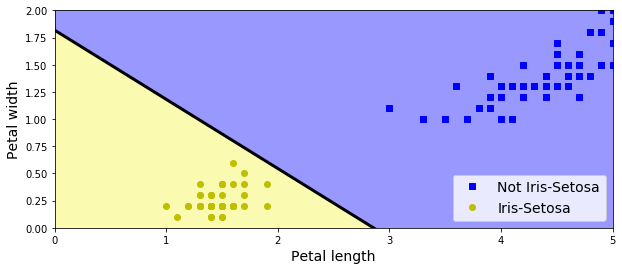

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

# Activation functions

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

[-5, 5, -0.2, 1.2]

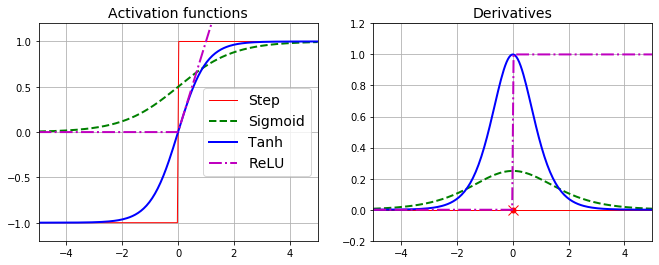

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

In [7]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

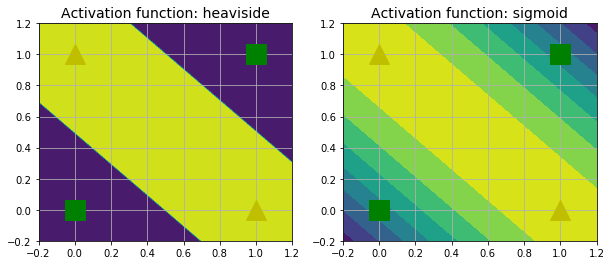

In [8]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import TensorFlow and Keras.

In [9]:
from tensorflow import keras

In [10]:
tf.__version__

'1.14.0'

In [11]:
keras.__version__

'2.2.4-tf'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [12]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [13]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [14]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [15]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

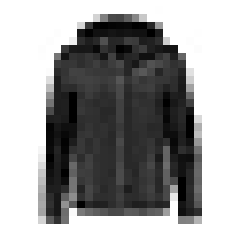

In [16]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [17]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [18]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [19]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

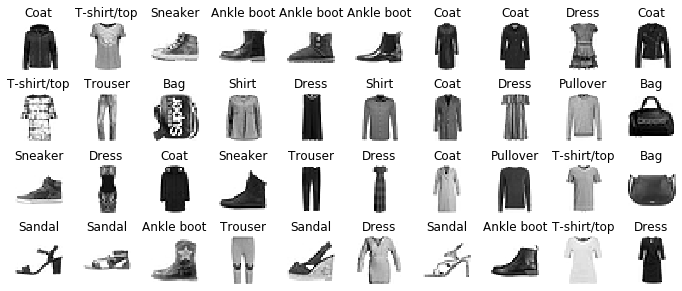

In [22]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

W0724 00:53:52.711835 4389889472 deprecation.py:506] From /opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_random_seed(42)

In [25]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.layers

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


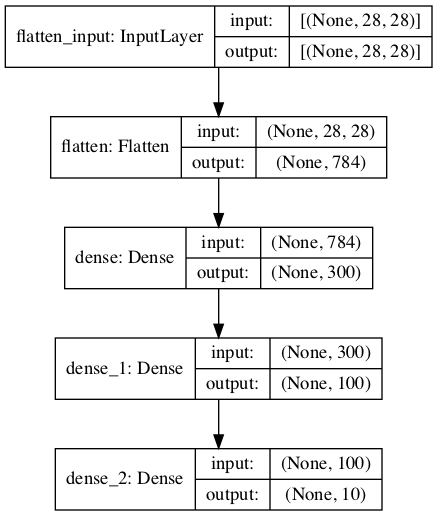

In [28]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [30]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [31]:
model.get_layer(hidden1.name) is hidden1

True

In [32]:
weights, biases = hidden1.get_weights()

In [33]:
weights

array([[ 0.01513953, -0.00182861,  0.0646853 , ...,  0.04114765,
         0.00448342,  0.06432123],
       [ 0.07068136, -0.07170715,  0.02270165, ..., -0.00219323,
        -0.06530555,  0.05230799],
       [ 0.00088049, -0.04335928,  0.02484499, ..., -0.0181252 ,
        -0.04382037,  0.00582965],
       ...,
       [ 0.06951119, -0.04154188, -0.0631083 , ..., -0.06399027,
         0.05743755, -0.02660926],
       [ 0.04145878, -0.05679043, -0.02418258, ...,  0.06427447,
         0.04248022, -0.00580377],
       [-0.02178467, -0.01062121,  0.011522  , ..., -0.01790331,
         0.02122946, -0.06212726]], dtype=float32)

In [34]:
weights.shape

(784, 300)

In [35]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [36]:
biases.shape

(300,)

In [37]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [38]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 6s 115us/sample - loss: 0.7314 - acc: 0.7600 - val_loss: 0.5058 - val_acc: 0.8408
Epoch 2/30
55000/55000 [==============================] - 6s 113us/sample - loss: 0.4903 - acc: 0.8305 - val_loss: 0.4569 - val_acc: 0.8456
Epoch 3/30
55000/55000 [==============================] - 6s 117us/sample - loss: 0.4446 - acc: 0.8440 - val_loss: 0.4117 - val_acc: 0.8586
Epoch 4/30
55000/55000 [==============================] - 6s 116us/sample - loss: 0.4178 - acc: 0.8527 - val_loss: 0.4032 - val_acc: 0.8658
Epoch 5/30
55000/55000 [==============================] - 7s 125us/sample - loss: 0.3971 - acc: 0.8605 - val_loss: 0.3808 - val_acc: 0.8692
Epoch 6/30
55000/55000 [==============================] - 6s 116us/sample - loss: 0.3808 - acc: 0.8659 - val_loss: 0.3797 - val_acc: 0.8714
Epoch 7/30
55000/55000 [==============================] - 7s 118us/sample - loss: 0.3665 - acc: 0.8709 - val_lo

In [39]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': None,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

In [40]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [41]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

(0, 1)

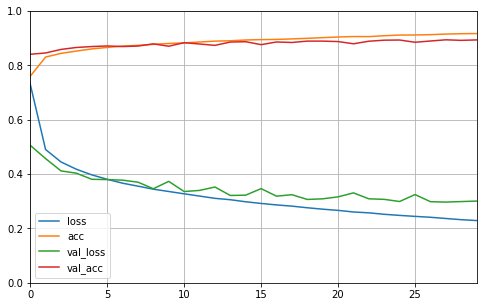

In [42]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

In [43]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 81us/sample - loss: 0.3330 - acc: 0.8855


[0.3329879164338112, 0.8855]

In [44]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.02, 0.  , 0.96],
       [0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [45]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [46]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [47]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

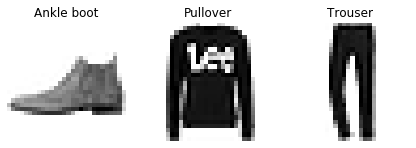

In [49]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

# Regression MLP

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [50]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

I0724 01:01:14.524346 4389889472 california_housing.py:114] Downloading Cal. housing from https://ndownloader.figshare.com/files/5976036 to /Users/guilleaf/scikit_learn_data


In [52]:
np.random.seed(42)
tf.random.set_random_seed(42)

In [53]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 68us/sample - loss: 1.9525 - val_loss: 1.0396
Epoch 2/20
11610/11610 [==============================] - 1s 61us/sample - loss: 0.7868 - val_loss: 0.7356
Epoch 3/20
11610/11610 [==============================] - 1s 52us/sample - loss: 0.6986 - val_loss: 0.6678
Epoch 4/20
11610/11610 [==============================] - 1s 66us/sample - loss: 0.6464 - val_loss: 0.6140
Epoch 5/20
11610/11610 [==============================] - 1s 63us/sample - loss: 0.6064 - val_loss: 0.5761
Epoch 6/20
11610/11610 [==============================] - 1s 62us/sample - loss: 0.5733 - val_loss: 0.5512
Epoch 7/20
11610/11610 [==============================] - 1s 59us/sample - loss: 0.5464 - val_loss: 0.5330
Epoch 8/20
11610/11610 [==============================] - 1s 64us/sample - loss: 0.5244 - val_loss: 0.4966
Epoch 9/20
11610/11610 [==============================] - 1s 61us/sample - loss: 0.5056 - val_l

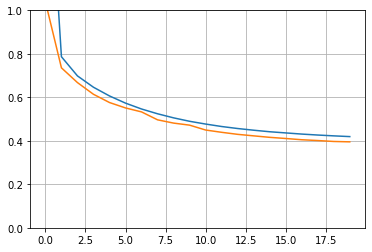

In [54]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [55]:
y_pred

array([[0.64346564],
       [1.5651062 ],
       [3.4509287 ]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [57]:
np.random.seed(42)
tf.random.set_random_seed(42)

In [58]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [60]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 77us/sample - loss: 1.9466 - val_loss: 0.8385
Epoch 2/20
11610/11610 [==============================] - 1s 62us/sample - loss: 0.6983 - val_loss: 0.8671
Epoch 3/20
11610/11610 [==============================] - 1s 61us/sample - loss: 0.6432 - val_loss: 0.8649
Epoch 4/20
11610/11610 [==============================] - 1s 62us/sample - loss: 0.6010 - val_loss: 0.6220
Epoch 5/20
11610/11610 [==============================] - 1s 57us/sample - loss: 0.5694 - val_loss: 0.6816
Epoch 6/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.5429 - val_loss: 0.5339
Epoch 7/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.5207 - val_loss: 0.4908
Epoch 8/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5018 - val_loss: 0.4819
Epoch 9/20
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4857 - val_l

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [62]:
np.random.seed(42)
tf.random.set_random_seed(42)

In [63]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [64]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 82us/sample - loss: 2.6280 - val_loss: 1.6627
Epoch 2/20
11610/11610 [==============================] - 1s 82us/sample - loss: 0.8260 - val_loss: 0.7156
Epoch 3/20
11610/11610 [==============================] - 1s 64us/sample - loss: 0.7026 - val_loss: 0.6425
Epoch 4/20
11610/11610 [==============================] - 1s 61us/sample - loss: 0.6484 - val_loss: 0.6206
Epoch 5/20
11610/11610 [==============================] - 1s 68us/sample - loss: 0.6098 - val_loss: 0.5902
Epoch 6/20
11610/11610 [==============================] - 1s 80us/sample - loss: 0.5781 - val_loss: 0.5979
Epoch 7/20
11610/11610 [==============================] - 1s 64us/sample - loss: 0.5507 - val_loss: 0.6098
Epoch 8/20
11610/11610 [==============================] - 1s 66us/sample - loss: 0.5281 - val_loss: 0.5427
Epoch 9/20
11610/11610 [==============================] - 1s 63us/sample - loss: 0.5082 - val_l

Adding an auxiliary output for regularization:

In [66]:
np.random.seed(42)
tf.random.set_random_seed(42)

In [67]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [68]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [69]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 106us/sample - loss: 2.5937 - main_output_loss: 2.3062 - aux_output_loss: 5.1748 - val_loss: 1.5937 - val_main_output_loss: 1.2186 - val_aux_output_loss: 4.9694
Epoch 2/20
11610/11610 [==============================] - 1s 80us/sample - loss: 1.1421 - main_output_loss: 0.9120 - aux_output_loss: 3.2094 - val_loss: 1.2974 - val_main_output_loss: 0.8512 - val_aux_output_loss: 5.3121
Epoch 3/20
11610/11610 [==============================] - 1s 69us/sample - loss: 0.8820 - main_output_loss: 0.7317 - aux_output_loss: 2.2369 - val_loss: 1.2161 - val_main_output_loss: 0.7215 - val_aux_output_loss: 5.6658
Epoch 4/20
11610/11610 [==============================] - 1s 75us/sample - loss: 0.7647 - main_output_loss: 0.6538 - aux_output_loss: 1.7621 - val_loss: 1.1188 - val_main_output_loss: 0.6196 - val_aux_output_loss: 5.6071
Epoch 5/20
11610/11610 [==============================] - 1s 70us/

In [70]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5160/5160 [==============================] - 0s 31us/sample - loss: 0.4555 - main_output_loss: 0.4199 - aux_output_loss: 0.7778


# The subclassing API

In [71]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [72]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 84us/sample - loss: 2.7178 - output_1_loss: 2.4699 - output_2_loss: 4.9402 - val_loss: 2.6568 - val_output_1_loss: 2.5391 - val_output_2_loss: 3.7091
Epoch 2/10
11610/11610 [==============================] - 1s 67us/sample - loss: 1.1701 - output_1_loss: 0.9543 - output_2_loss: 3.1082 - val_loss: 1.4790 - val_output_1_loss: 1.3579 - val_output_2_loss: 2.5663
Epoch 3/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.9041 - output_1_loss: 0.7639 - output_2_loss: 2.1632 - val_loss: 1.0201 - val_output_1_loss: 0.8963 - val_output_2_loss: 2.1357
Epoch 4/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.7942 - output_1_loss: 0.6898 - output_2_loss: 1.7338 - val_loss: 0.8436 - val_output_1_loss: 0.7171 - val_output_2_loss: 1.9811
Epoch 5/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.7348 - output_1_loss: 0.

In [73]:
model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [75]:
np.random.seed(42)
tf.random.set_random_seed(42)

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [77]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 86us/sample - loss: 2.0278 - val_loss: 2.0277
Epoch 2/10
11610/11610 [==============================] - 1s 78us/sample - loss: 0.8232 - val_loss: 0.8391
Epoch 3/10
11610/11610 [==============================] - 1s 58us/sample - loss: 0.6720 - val_loss: 0.6311
Epoch 4/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.6037 - val_loss: 0.5577
Epoch 5/10
11610/11610 [==============================] - 1s 60us/sample - loss: 0.5577 - val_loss: 0.5187
Epoch 6/10
11610/11610 [==============================] - 1s 61us/sample - loss: 0.5232 - val_loss: 0.4881
Epoch 7/10
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4967 - val_loss: 0.4646
Epoch 8/10
11610/11610 [==============================] - 1s 62us/sample - loss: 0.4764 - val_loss: 0.4484
Epoch 9/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4599 - val_l

In [78]:
model.save("my_keras_model.h5")

In [79]:
model = keras.models.load_model("my_keras_model.h5")

W0724 01:12:40.872753 4389889472 deprecation.py:506] From /opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 01:12:40.874850 4389889472 deprecation.py:506] From /opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [80]:
model.predict(X_new)

array([[0.6043376],
       [1.5900153],
       [3.3774152]], dtype=float32)

In [81]:
model.save_weights("my_keras_weights.ckpt")

In [82]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

In [84]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_random_seed(42)

In [85]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [86]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 71us/sample - loss: 1.6168 - val_loss: 1.0699
Epoch 2/10
11610/11610 [==============================] - 1s 61us/sample - loss: 0.6601 - val_loss: 0.6115
Epoch 3/10
11610/11610 [==============================] - 1s 73us/sample - loss: 0.5867 - val_loss: 0.5322
Epoch 4/10
11610/11610 [==============================] - 1s 53us/sample - loss: 0.5432 - val_loss: 0.4934
Epoch 5/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.5104 - val_loss: 0.4700
Epoch 6/10
11610/11610 [==============================] - 1s 57us/sample - loss: 0.4857 - val_loss: 0.4482
Epoch 7/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4660 - val_loss: 0.4283
Epoch 8/10
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4511 - val_loss: 0.4279
Epoch 9/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4388 - val_l

In [87]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 72us/sample - loss: 0.4293 - val_loss: 0.4222
Epoch 2/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.4211 - val_loss: 0.4193
Epoch 3/100
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4145 - val_loss: 0.4377
Epoch 4/100
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4094 - val_loss: 0.4260
Epoch 5/100
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4047 - val_loss: 0.4213
Epoch 6/100
11610/11610 [==============================] - 1s 70us/sample - loss: 0.4004 - val_loss: 0.4167
Epoch 7/100
11610/11610 [==============================] - 1s 57us/sample - loss: 0.3969 - val_loss: 0.4249
Epoch 8/100
11610/11610 [==============================] - 1s 59us/sample - loss: 0.3936 - val_loss: 0.4236
Epoch 9/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.390

In [88]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [89]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
10816/11610 [==========================>...] - ETA: 0s - loss: 0.3749
val/train: 1.05
11610/11610 [==============================] - 1s 53us/sample - loss: 0.3763 - val_loss: 0.3942
